<a href="https://colab.research.google.com/github/maro9450/SML/blob/main/lab/mnist_twolayers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

# use GPU for computations if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# temporarily patch this script until the MNIST data set download issue is resolved
# https://github.com/pytorch/vision/issues/1938
import urllib.request
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Classification of hand-written digits

We start by downloading and extracting the MNIST data set.

In [2]:
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transforms.ToTensor())

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transforms.ToTensor())

# extract a complete PyTorch dataset
def extract(dataset):
    datasize = len(dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=datasize, shuffle=False)
    return next(iter(dataloader))

# extract all test images and labels into PyTorch tensors
# the training data will be loaded in batches during training
test_X, test_Y = extract(testset)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 41.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.53MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## The model

The input data $X$ are grayscale images of $28\times 28$ pixels. The first dimension will be the number of data points that are provided to the network. The input data is flattend into a matrix with $28 \times 28 = 784$ columns using `X.view(-1, 784)`, where each colum represents one pixel. We then apply first the sigmoid $Q=\sigma (X W^{(1)} + b^{(1)})$ for the hidden layer, and then apply the softmax to $QW^{(2)} + b^{(2)}$ to get the class probabilities.

In [9]:
class Net(nn.Module):
    def __init__(self, U=200):
        super(Net, self).__init__()
        # the weights of dimension (784, 10)
        self.W1 = nn.Parameter(0.1 * torch.randn(784, U))
        self.b1 = nn.Parameter(torch.zeros(U))
        self.W2 = nn.Parameter(0.1 * torch.randn(U, 10))
        self.b2 = nn.Parameter(torch.zeros(10))

    def forward(self, X):
        # flatten the data into a matrix with 28 x 28 = 784 columns
        X = X.view(-1, 784)
        # sigmoided hidden layer
        Q = torch.sigmoid(X.mm(self.W1) + self.b1)
        # apply the softmax function
        G = F.softmax(Q.mm(self.W2) + self.b2, dim=1)
        return G

In [20]:
df_acc = pd.DataFrame({'iteration': np.arange(0,2000+1,step=100)})
df_ent = pd.DataFrame({'iteration': np.arange(0,2000+1,step=100)})

## The training

We define the cross-entropy for the predicted probabilities $G$ (10-dimensional vectors) and the labels $Y$ (integers between 0 and 9).

In [10]:
def crossentropy(G, Y):
    # convert labels to onehot encoding
    Y_onehot = torch.eye(10, device=device)[Y] #n*10 tensor of n 1-hot-encoded Y:s

    return -(Y_onehot * G.log()).sum(dim = 1).mean() #cost (eq 10)

The next lines evaluate the accuracy of the predictions.

In [11]:
def accuracy(G, Y):
    #G = nx10 matrix of class probabilities
    #G.argmax returns the index of the most likely class (ie. the class)
    #G.argmax==Y is indicator for correct prediction. Mean yields prob of correct classification.
    return (G.argmax(dim=1) == Y).float().mean()

We are ready to train the network.

In [38]:
# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []


# initialize the neural network and move it to the GPU if needed
net = Net(U=200)
net.to(device)

# define the optimization algorithm
learningrate = 0.5
optimizer = optim.SGD(net.parameters(), lr=learningrate)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

# perform multiple training steps
total_iterations = 2000 # total number of iterations
t = 0 # current iteration
done = False
while not done:
    for (batch_X, batch_Y) in trainloader:
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        loss = crossentropy(batch_G, batch_Y)

        # backpropagation
        loss.backward()

        # perform gradient descent step
        optimizer.step()

        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)

            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                G = net(X)
                test_crossentropy.append(crossentropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

                # print the iteration number and the accuracy of the predictions
                print(f"Step {t:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train cross-entropy {train_crossentropy[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test cross-entropy {test_crossentropy[-1]:5.2f}")

        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break

Step     0: train accuracy   6.00% train cross-entropy  2.58  test accuracy  10.24% test cross-entropy  3.19
Step   100: train accuracy  84.00% train cross-entropy  0.60  test accuracy  86.02% test cross-entropy  0.50
Step   200: train accuracy  85.00% train cross-entropy  0.44  test accuracy  89.76% test cross-entropy  0.36
Step   300: train accuracy  90.00% train cross-entropy  0.51  test accuracy  90.44% test cross-entropy  0.33
Step   400: train accuracy  86.00% train cross-entropy  0.36  test accuracy  91.38% test cross-entropy  0.31
Step   500: train accuracy  93.00% train cross-entropy  0.32  test accuracy  91.21% test cross-entropy  0.30
Step   600: train accuracy  88.00% train cross-entropy  0.29  test accuracy  92.23% test cross-entropy  0.28
Step   700: train accuracy  92.00% train cross-entropy  0.34  test accuracy  92.18% test cross-entropy  0.27
Step   800: train accuracy  94.00% train cross-entropy  0.21  test accuracy  92.70% test cross-entropy  0.26
Step   900: train a

## The evaluation

The remaining code produces the plots needed to evaluate the training and predictions.

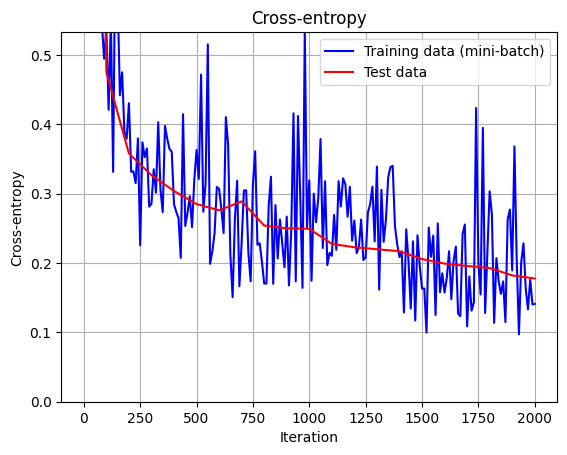

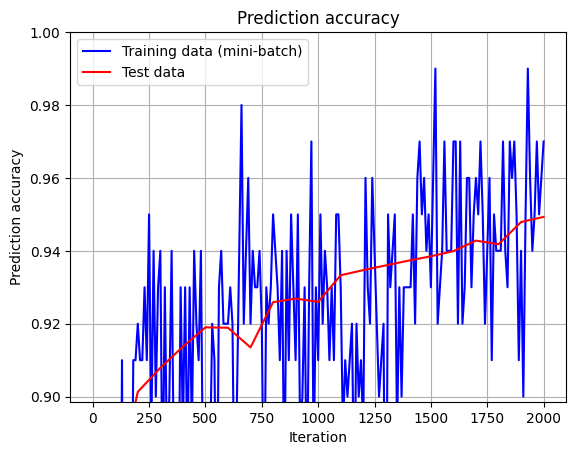

In [32]:
# plot the cross-entropy
plt.plot(train_iter, train_crossentropy, 'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_crossentropy, 'r-', label='Test data')
plt.xlabel('Iteration')
plt.ylabel('Cross-entropy')
plt.ylim([0, min(test_crossentropy) * 3])
plt.title('Cross-entropy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

# plot the accuracy
plt.plot(train_iter, train_accuracy, 'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_accuracy, 'r-', label='Test data')
plt.xlabel('Iteration')
plt.ylabel('Prediction accuracy')
plt.ylim([max(1 - (1 - test_accuracy[-1]) * 2, 0), 1])
plt.title('Prediction accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.show()


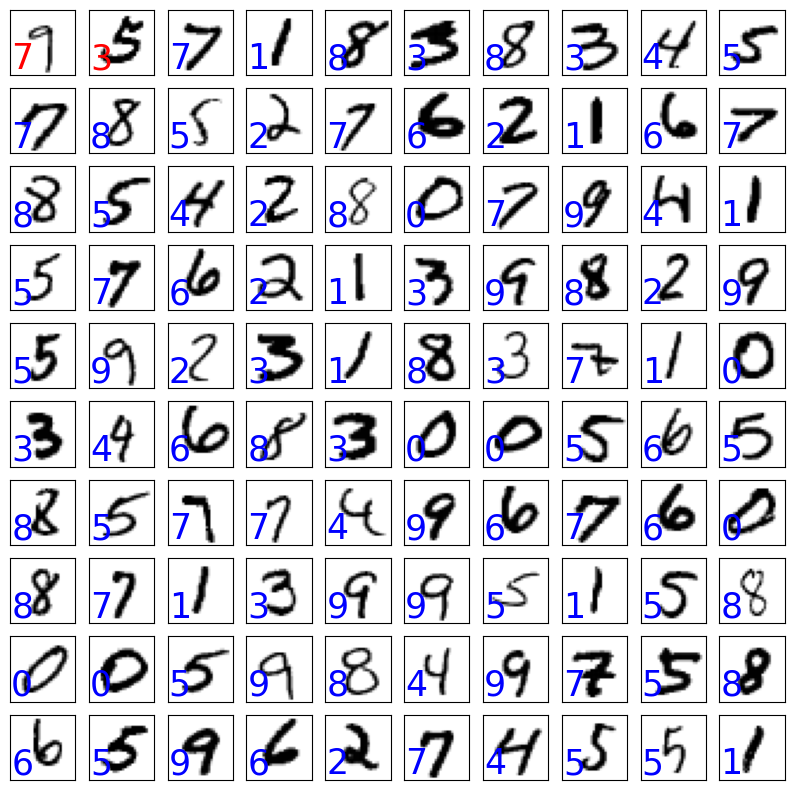

In [33]:
# evaluate the network on 100 random test images
with torch.no_grad():
    # obtain 100 random samples from the test data set
    random_X, random_Y = next(iter(torch.utils.data.DataLoader(testset, batch_size=100, shuffle=True)))

    # move data to the GPU if needed
    random_X, random_Y = random_X.to(device), random_Y.to(device)

    # compute the predictions for the sampled inputs
    random_G = net(random_X)
    random_Yhat = random_G.argmax(dim=1)

    # sort the predictions with the incorrect ones first
    indices_incorrect_first = (random_Yhat == random_Y).float().argsort()

# plot the images
num_rows = 10
num_cols = 10
num_images = num_rows * num_cols
plt.figure(figsize=(num_cols, num_rows))

for i, index in enumerate(indices_incorrect_first, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.xticks([])
    plt.yticks([])

    # plot the image
    plt.imshow(random_X[index, :, :].view(28, 28).cpu().numpy(), cmap=plt.cm.binary)

    # add the prediction as annotation (incorrect predictions in red, correct ones in blue)
    color = 'blue' if random_Yhat[index] == random_Y[index] else 'red'
    plt.text(0, 25, random_Yhat[index].item(), fontsize=25, color=color)

plt.show()

In [39]:
df_acc_test = pd.DataFrame({'iteration': np.arange(0,2000+1,step=100),
                            200: test_accuracy})
df_ent_test = pd.DataFrame({'iteration': np.arange(0,2000+1,step=100),
                            200: test_crossentropy})
df_acc_train = pd.DataFrame({'iteration': np.arange(0,2000+1,step=10),
                            200: train_accuracy})
df_ent_train = pd.DataFrame({'iteration': np.arange(0,2000+1,step=10),
                            200: train_crossentropy})



U = [10, 25, 50, 100, 250, 500, 750]



for u in U:
    # initialize the test and training error statistics
    test_accuracy = []
    test_crossentropy = []
    test_iter = []
    train_accuracy = []
    train_crossentropy = []
    train_iter = []


    # initialize the neural network and move it to the GPU if needed
    net = Net(u)
    net.to(device)

    # define the optimization algorithm
    learningrate = 0.5
    optimizer = optim.SGD(net.parameters(), lr=learningrate)

    # define the data loader for batches of the training data
    batchsize = 100
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

    # perform multiple training steps
    t = 0 # current iteration
    done = False
    while not done:
        for (batch_X, batch_Y) in trainloader:
            # move batch to the GPU if needed
            batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            batch_G = net(batch_X)
            loss = crossentropy(batch_G, batch_Y)

            # backpropagation
            loss.backward()

            # perform gradient descent step
            optimizer.step()

            # don't bother too much about the following lines!
            with torch.no_grad():
                # evaluate the performance on the training data at every 10th iteration
                if t % 10 == 0:
                    train_crossentropy.append(loss.item())
                    train_accuracy.append(accuracy(batch_G, batch_Y).item())
                    train_iter.append(t)

                # evaluate the performance on the test data at every 100th iteration
                if t % 100 == 0:
                    # move test data to the GPU if needed
                    X, Y = test_X.to(device), test_Y.to(device)

                    # compute predictions for the test data
                    G = net(X)
                    test_crossentropy.append(crossentropy(G, Y).item())
                    test_accuracy.append(accuracy(G, Y).item())
                    test_iter.append(t)

            # stop the training after the specified number of iterations
            t += 1
            if t > total_iterations:
                done = True
                break

    df_acc_test[u] = test_accuracy
    df_ent_test[u] = test_crossentropy
    df_acc_train[u] = train_accuracy
    df_ent_train[u] = train_crossentropy


We now plot the test results for all our nets.

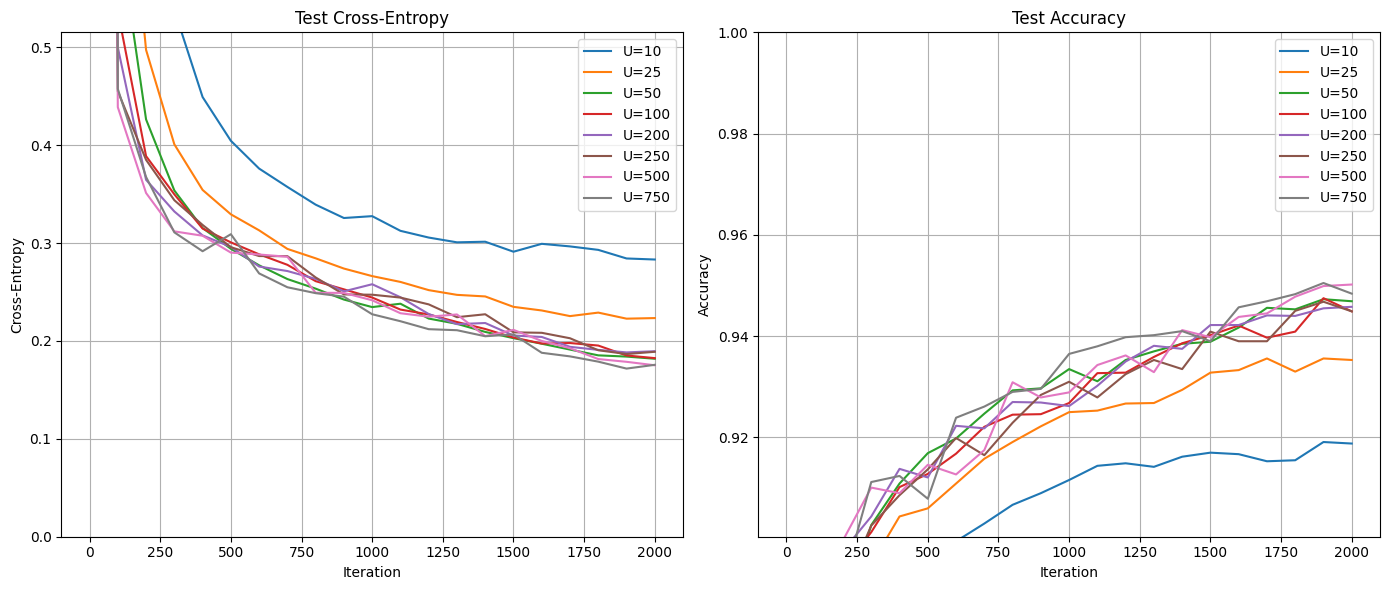

In [42]:
# Define the list of U-values to use for the test plots
U = [10, 25, 50, 100, 200, 250, 500, 750]

# Set up the 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1st Subplot: Cross-Entropy (Test Data)
for idx, u in enumerate(U):
    axes[0].plot(df_ent_test['iteration'], df_ent_test[u], label=f'U={u}')
min_ent_test = min(df_ent_test[U].min())
axes[0].set_ylim([0, 3 * min_ent_test])
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Cross-Entropy')
axes[0].set_title('Test Cross-Entropy')
axes[0].grid(True)
axes[0].legend(loc='best')

# 2nd Subplot: Accuracy (Test Data)
for idx, u in enumerate(U):
    axes[1].plot(df_acc_test['iteration'], df_acc_test[u], label=f'U={u}')
final_test_acc = df_acc_test[U].iloc[-1].max()
axes[1].set_ylim([max(1 - (1 - final_test_acc) * 2, 0), 1])
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Test Accuracy')
axes[1].grid(True)
axes[1].legend(loc='best')

# Adjust the layout to make the plots more readable
plt.tight_layout()
plt.show()

Now we consider the case where we initialize with parameters set to zero

In [43]:
# initialize the test and training error statistics
test_accuracy = []
test_crossentropy = []
test_iter = []
train_accuracy = []
train_crossentropy = []
train_iter = []


# initialize the neural network and move it to the GPU if needed
net = Net(U=200)

#setting weights equal to zero
with torch.no_grad():  # Disable gradient tracking
    net.W1.zero_()
    net.b1.zero_()
    net.W2.zero_()
    net.b2.zero_()

net.to(device)

# define the optimization algorithm
optimizer = optim.SGD(net.parameters(), lr=learningrate)

# define the data loader for batches of the training data
batchsize = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, num_workers=2, shuffle=True)

# perform multiple training steps
t = 0 # current iteration
done = False
while not done:
    for (batch_X, batch_Y) in trainloader:
        # move batch to the GPU if needed
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        batch_G = net(batch_X)
        loss = crossentropy(batch_G, batch_Y)

        # backpropagation
        loss.backward()

        # perform gradient descent step
        optimizer.step()

        # don't bother too much about the following lines!
        with torch.no_grad():
            # evaluate the performance on the training data at every 10th iteration
            if t % 10 == 0:
                train_crossentropy.append(loss.item())
                train_accuracy.append(accuracy(batch_G, batch_Y).item())
                train_iter.append(t)

            # evaluate the performance on the test data at every 100th iteration
            if t % 100 == 0:
                # move test data to the GPU if needed
                X, Y = test_X.to(device), test_Y.to(device)

                # compute predictions for the test data
                G = net(X)
                test_crossentropy.append(crossentropy(G, Y).item())
                test_accuracy.append(accuracy(G, Y).item())
                test_iter.append(t)

                # print the iteration number and the accuracy of the predictions
                print(f"Step {t:5d}: train accuracy {100 * train_accuracy[-1]:6.2f}% " \
                      f"train cross-entropy {train_crossentropy[-1]:5.2f}  " \
                      f"test accuracy {100 * test_accuracy[-1]:6.2f}% " \
                      f"test cross-entropy {test_crossentropy[-1]:5.2f}")

        # stop the training after the specified number of iterations
        t += 1
        if t > total_iterations:
            done = True
            break

Step     0: train accuracy   9.00% train cross-entropy  2.30  test accuracy  10.09% test cross-entropy  2.55
Step   100: train accuracy  16.00% train cross-entropy  2.23  test accuracy  18.66% test cross-entropy  2.22
Step   200: train accuracy  22.00% train cross-entropy  2.08  test accuracy  25.53% test cross-entropy  2.03
Step   300: train accuracy  30.00% train cross-entropy  1.90  test accuracy  27.38% test cross-entropy  1.91
Step   400: train accuracy  28.00% train cross-entropy  1.84  test accuracy  28.97% test cross-entropy  1.83
Step   500: train accuracy  33.00% train cross-entropy  1.74  test accuracy  33.08% test cross-entropy  1.76
Step   600: train accuracy  51.00% train cross-entropy  1.33  test accuracy  43.79% test cross-entropy  1.40
Step   700: train accuracy  53.00% train cross-entropy  1.29  test accuracy  62.86% test cross-entropy  1.10
Step   800: train accuracy  61.00% train cross-entropy  0.96  test accuracy  69.48% test cross-entropy  0.92
Step   900: train a

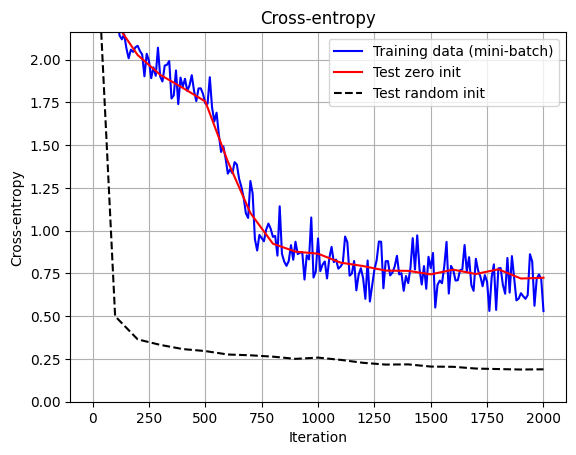

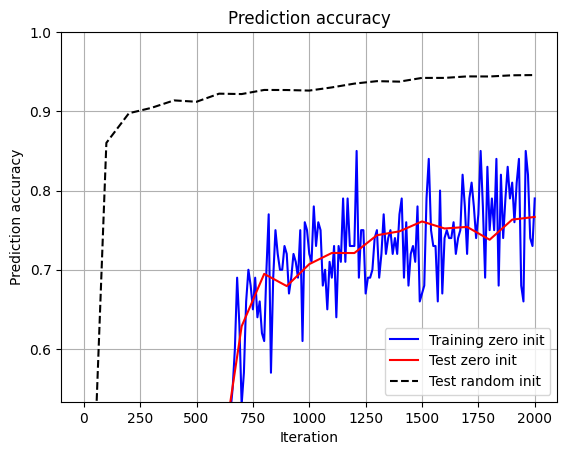

In [44]:
# plot the cross-entropy
plt.plot(train_iter, train_crossentropy, 'b-', label='Training data (mini-batch)')
plt.plot(test_iter, test_crossentropy, 'r-', label='Test zero init')
plt.plot(test_iter, df_ent_test[200], 'k--', label='Test random init')
plt.xlabel('Iteration')
plt.ylabel('Cross-entropy')
plt.ylim([0, min(test_crossentropy) * 3])
plt.title('Cross-entropy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

# plot the accuracy
plt.plot(train_iter, train_accuracy, 'b-', label='Training zero init')
plt.plot(test_iter, test_accuracy, 'r-', label='Test zero init')
plt.plot(test_iter, df_acc_test[200], 'k--', label='Test random init')
plt.xlabel('Iteration')
plt.ylabel('Prediction accuracy')
plt.ylim([max(1 - (1 - test_accuracy[-1]) * 2, 0), 1])
plt.title('Prediction accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.show()

**Question 4.4:** With $U=200$ we get around 95% accuracy. Using different values of $U$, we appear to be getting diminishing returns with more than $50$ hidden units. The accuracy is then roughly the same, with a similar convergence speed.

Initializing the net with zero vectors vastly reduces the effectiveness of the model. This is caused by symmetry, as equal weights mean that all nodes are treated equally and the hidden nodes thus compute the same function, with equal gradient. Backpropogating will then result in moving in a manner similar to the gradient (no new direction to be gained) and thus the optimization process is halted.